##### Copyright 2019 The TensorFlow Authors.

# Transfer learning and fine-tuning

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


two classes transfer learning accuracy 100% on retraining.

In [ ]:
# !pip3 install -q tf-nightly

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
# Preparing local copy of "partial" core50 data


## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [4]:
# Execute below two line to perform one time download to your machine
#_URL2 = 'http://bias.csr.unibo.it/maltoni/download/core50/core50_128x128.zip'
#path_to_zip = tf.keras.utils.get_file('core50_128x128.zip', origin=_URL2, extract=True)

# -------------------
def source_data(source):
    #swaps the data for testing
    #path_to_zip = 'c:\\Users\\Home\\.keras\\datasets\\'
    path_to_zip = '/home/ubuntu/cvpr_clvision_challenge/core50/data/'
    PATH2 = os.path.join(os.path.dirname(path_to_zip), 'core50_128x128')
    print(PATH2)
    if source == 0:
        print("data source 0 is 0")
        train_dir0 = os.path.join(PATH2, 't0')
        validation_dir0 = os.path.join(PATH2, 'v0')
        train_dir1 = os.path.join(PATH2, 't1')
        validation_dir1 = os.path.join(PATH2, 'v1')        
    elif source == 1:
        print("data source 0 is 1")
        train_dir1 = os.path.join(PATH2, 't0')
        validation_dir1 = os.path.join(PATH2, 'v0')
        train_dir0 = os.path.join(PATH2, 't1')
        validation_dir0 = os.path.join(PATH2, 'v1')
    elif source == 2:
        print("data source 0 is 2")
        train_dir1 = os.path.join(PATH2, 's3')
        validation_dir1 = os.path.join(PATH2, 's3')
        train_dir0 = os.path.join(PATH2, 's2')
        validation_dir0 = os.path.join(PATH2, 's2')
    elif source == 3:
        print("data source 0 is 3")
        train_dir1 = os.path.join(PATH2, 's2')
        validation_dir1 = os.path.join(PATH2, 's2')
        train_dir0 = os.path.join(PATH2, 's3')
        validation_dir0 = os.path.join(PATH2, 's3')
    elif source == 4:
        print("data source 0 is 3")
        train_dir1 = os.path.join(PATH2, 's2')
        validation_dir1 = os.path.join(PATH2, 's2')
        train_dir0 = os.path.join(PATH2, 't23')
        validation_dir0 = os.path.join(PATH2, 't23')
    else:
        print("no input")
        
    return (train_dir0,validation_dir0,train_dir1,validation_dir1)

In [5]:
## train_dir0,validation_dir0,train_dir1,validation_dir1 = source_data(2)

In [6]:
def trainset(train_dir,BATCH_SIZE = 64,IMG_SIZE = (128, 128)):
    #BATCH_SIZE = 32
    #IMG_SIZE = (160, 160) original
    train_dataset = image_dataset_from_directory(train_dir,
                                                 shuffle=True,
                                                 batch_size=BATCH_SIZE,
                                                 image_size=IMG_SIZE)
    print(train_dataset.class_names)
    return train_dataset



In [7]:
##train_dataset0 = trainset(train_dir0)
## train_dataset1 = trainset(train_dir1)

'''
for i, train_batch in enumerate(train_dataset0):
    train_x, train_y, t = train_batch

    print("----------- batch {0} -------------".format(i))
    '''

'\nfor i, train_batch in enumerate(train_dataset0):\n    train_x, train_y, t = train_batch\n\n    print("----------- batch {0} -------------".format(i))\n    '

In [8]:
#image_batch, label_batch = train_dataset0.as_numpy_iterator().next()

In [9]:
#label_batch

In [10]:
#dir(train_dataset0)
#train_dataset0.batch(32)

In [11]:
#print(vars(train_dataset))
#print(dir(train_dataset))

In [12]:
def val_dataset(validation_dir,BATCH_SIZE = 64,IMG_SIZE = (128, 128)):
    validation_dataset = image_dataset_from_directory(validation_dir,
                                                      shuffle=True,
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMG_SIZE)
    print(validation_dataset.class_names)
    return validation_dataset



In [13]:
## validation_dataset0 = val_dataset(validation_dir0)
## validation_dataset1 = val_dataset(validation_dir1)



Show the first nine images and labels from the training set:

In [14]:
'''
def show3_images(dataset):
    class_names = dataset.class_names
    print(dataset.take(1))
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
      for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    
show3_images(train_dataset0)
show3_images(train_dataset1)
show3_images(validation_dataset0)
show3_images(validation_dataset1)
'''

'\ndef show3_images(dataset):\n    class_names = dataset.class_names\n    print(dataset.take(1))\n    plt.figure(figsize=(10, 10))\n    for images, labels in dataset.take(1):\n      for i in range(3):\n        ax = plt.subplot(3, 3, i + 1)\n        plt.imshow(images[i].numpy().astype("uint8"))\n        plt.title(class_names[labels[i]])\n        plt.axis("off")\n    \nshow3_images(train_dataset0)\nshow3_images(train_dataset1)\nshow3_images(validation_dataset0)\nshow3_images(validation_dataset1)\n'

As the original dataset doesn't contains a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [15]:
def test_dataset(validation_dataset):
    val_batches = tf.data.experimental.cardinality(validation_dataset) #number of sets = BATCH_SIZE
    test_dataset = validation_dataset.take(val_batches // 5) # test = 32 // 5 = 6 taken from validation
    validation_dataset = validation_dataset.skip(val_batches // 5) # so validation to skip(6) = 32-6=26
    print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
    print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
    print(test_dataset)
    print(validation_dataset)
    
    return (val_batches,test_dataset,validation_dataset)



In [16]:
## val_batches0,test_dataset0,validation_dataset0 = test_dataset(validation_dataset0)   
## val_batches1,test_dataset1,validation_dataset1 = test_dataset(validation_dataset1)  

### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [17]:
def prefetch(train,validation,test):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    train_dataset = train.prefetch(buffer_size=AUTOTUNE)
    validation_dataset = validation.prefetch(buffer_size=AUTOTUNE)
    test_dataset = test.prefetch(buffer_size=AUTOTUNE)
    
    return (train_dataset,validation_dataset,test_dataset)



In [18]:
## train_dataset0,validation_dataset0,test_dataset0 = prefetch(train_dataset0,validation_dataset0,test_dataset0)
## train_dataset1,validation_dataset1,test_dataset1 = prefetch(train_dataset1,validation_dataset1,test_dataset1)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [19]:
def data_aug():
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ])
    return data_augmentation


    
    

In [20]:
## data_augmentation = data_aug()

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

# run this as code to see augmentation effects
for image, _ in train_dataset.take(1): #take a single batch
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel vaues in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [21]:
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
def prepro_rescale():
    preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
    rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
    
    return (preprocess_input, rescale)



In [22]:
## preprocess_input, rescale = prepro_rescale()

Note: Alternatively, you could rescale pixel values from `[0,255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [23]:
# rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1,1]` or `[0,1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [24]:
def create_base():
    # Create the base model from the pre-trained model MobileNet V2
    IMG_SIZE=(128,128)
    IMG_SHAPE = IMG_SIZE + (3,)
    print("image size ", IMG_SIZE)
    print("image shape ", IMG_SHAPE)
    # base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    #print(base_model.summary())
    return base_model

In [25]:
#print(dir(base_model))
## base_model0 = create_base()
## base_model1 = create_base()

In [26]:
#base_model0.summary()

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [27]:
def feature_extractor(base_model,train_dataset):
    print("Freezing the convolutional base")
    base_model.trainable = False
    image_batch, label_batch = next(iter(train_dataset))
    feature_batch = base_model(image_batch)
    print(image_batch.shape) #image_batch)
    print(label_batch.shape) #label_batch)
    print(feature_batch.shape)
    
    return (base_model,image_batch,label_batch,feature_batch)
    


In [28]:
## base_model0,image_batch0,label_batch0,feature_batch0 = feature_extractor(base_model0,train_dataset0)
## base_model1,image_batch1,label_batch1,feature_batch1 = feature_extractor(base_model1,train_dataset1)

## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [29]:
# added to feature_extractor function
# base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [30]:
# Let's take a look at the base model architecture
#base_model0.summary()

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [31]:
def add_classify_head_layer(feature_batch):
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    print(global_average_layer)
    print(feature_batch_average.shape)
    
    return feature_batch_average



In [32]:
## feature_batch_average0 = add_classify_head_layer(feature_batch0)
## feature_batch_average1 = add_classify_head_layer(feature_batch1)

In [33]:
#base_model0.summary()

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [34]:
def add_predict_layer(feature_batch_average):
    #prediction_layer = tf.keras.layers.Dense(1, activation = 'sigmoid') #unable to prediction's single class
    prediction_layer = tf.keras.layers.Dense(1) # doesn't do well on 2+ classes 
    prediction_batch = prediction_layer(feature_batch_average)
    print(prediction_batch.shape)
    
    return prediction_batch


    

In [35]:
## prediction_batch0 = add_predict_layer(feature_batch_average0)
## prediction_batch1 = add_predict_layer(feature_batch_average1)

In [36]:
#base_model0.summary()

Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

# with augmentation
inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [37]:
def train_model(base_model):
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    #prediction_layer = tf.keras.layers.Dense(1, activation = 'sigmoid') #unable to prediction's single class
    prediction_layer = tf.keras.layers.Dense(1) # doesn't do well on 2+ classes 
    inputs = tf.keras.Input(shape=(128, 128, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print("trainable variables ", len(model.trainable_variables))
    
    return model



In [38]:
## train_model0 = train_model(base_model0)
## train_model1 = train_model(base_model1)

In [39]:
#train_model0.summary()

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [40]:
# added to train_model above
'''
base_learning_rate = 0.0001
model0.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
'''

"\nbase_learning_rate = 0.0001\nmodel0.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),\n              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),\n              metrics=['accuracy'])\n\nmodel1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),\n              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),\n              metrics=['accuracy'])\n"

In [41]:
#train_model0.summary()

In [42]:
#train_model1.summary()

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [43]:
def evaluate_dataset(train_model,validation_dataset):
    loss, accuracy = train_model.evaluate(validation_dataset)
    print("initial loss: {:.2f}".format(loss))
    print("initial accuracy: {:.2f}".format(accuracy))

In [44]:
## evaluate_dataset(train_model0, validation_dataset0)
## evaluate_dataset(train_model1, validation_dataset1)

In [45]:
def fit_train(train_model,train_dataset,validation_dataset,initial_epochs):
    print("fit train")
    history = train_model.fit(train_dataset,
                        epochs=initial_epochs,
                        validation_data=validation_dataset)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy - fit train')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss - fit train')
    plt.xlabel('epoch')
    plt.show()
    
    return (history,acc,val_acc,loss,val_loss)


In [46]:
## history0 = fit_train(train_model0,train_dataset0,validation_dataset0,initial_epochs=10)

In [47]:
## history1 = fit_train(train_model1,train_dataset1,validation_dataset1,initial_epochs=10)

In [48]:
# train_model0.summary()

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

In [49]:
# added to fit function
'''
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
'''

"\nacc = history.history['accuracy']\nval_acc = history.history['val_accuracy']\n\nloss = history.history['loss']\nval_loss = history.history['val_loss']\n\nplt.figure(figsize=(8, 8))\nplt.subplot(2, 1, 1)\nplt.plot(acc, label='Training Accuracy')\nplt.plot(val_acc, label='Validation Accuracy')\nplt.legend(loc='lower right')\nplt.ylabel('Accuracy')\nplt.ylim([min(plt.ylim()),1])\nplt.title('Training and Validation Accuracy')\n\nplt.subplot(2, 1, 2)\nplt.plot(loss, label='Training Loss')\nplt.plot(val_loss, label='Validation Loss')\nplt.legend(loc='upper right')\nplt.ylabel('Cross Entropy')\nplt.ylim([0,1.0])\nplt.title('Training and Validation Loss')\nplt.xlabel('epoch')\nplt.show()\n"

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [50]:
# print(len(base_model0.layers))

In [51]:
def tune_base_model(base_model,train_model,base_learning_rate = 0.0001):
    print("Unfreeze top layers")
    base_model.trainable = True
    # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))
    # Fine-tune from this layer onwards
    fine_tune_at = 100
    
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable =  False
    #print(base_model.summary())    
    train_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                       optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
                       metrics=['accuracy'])
    #print(train_model.summary())
    print("Number of trainable variables ", len(train_model.trainable_variables))
    
    return train_model


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [52]:
# added to tune_layers
'''
def compile_model(model):
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
                  metrics=['accuracy'])
    return model
'''


"\ndef compile_model(model):\n    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),\n                  optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),\n                  metrics=['accuracy'])\n    return model\n"

In [53]:
## tune_model0 = tune_base_model(base_model0,train_model0)
## tune_model1 = tune_base_model(base_model1,train_model1)

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [54]:
def model_fit2(model,train_dataset,validation_dataset,history,initial_epochs,fine_tune_epochs,acc,val_acc,loss,val_loss):
    print("model fit 2")
    # initial_epochs = 10
    # fine_tune_epochs = 10
    total_epochs =  initial_epochs + fine_tune_epochs

    history_fine = model.fit(train_dataset,
                             epochs=total_epochs,
                             initial_epoch=history.epoch[-1],
                             validation_data=validation_dataset)
    
    acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']

    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.8, 1])
    plt.plot([initial_epochs-1,initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy - fit2')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.plot([initial_epochs-1,initial_epochs-1],
             plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss - fit2')
    plt.xlabel('epoch')
    plt.show()
    
    return (history_fine,acc,val_acc,loss,val_loss)



    

In [55]:
## model_fit2(tune_model0,train_dataset0,validation_dataset0,history0)

In [56]:
## model_fit2(tune_model1,train_dataset1,validation_dataset1,history1)

In [57]:
#manually save weights
#!mkdir -p checkpoint
#model0.save_weights('./checkpoint/core50_101130_0')
#model1.save_weights('./checkpoint/core50_101130_1')

In [58]:
# save entire model
#!mkdir -p save_model
#model.save('save_model/core50_fitted_model_w_resnet50v2_1.h5')

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [59]:
'''
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
'''

"\nacc += history_fine.history['accuracy']\nval_acc += history_fine.history['val_accuracy']\n\nloss += history_fine.history['loss']\nval_loss += history_fine.history['val_loss']\n"

In [60]:
'''
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
'''

"\nplt.figure(figsize=(8, 8))\nplt.subplot(2, 1, 1)\nplt.plot(acc, label='Training Accuracy')\nplt.plot(val_acc, label='Validation Accuracy')\nplt.ylim([0.8, 1])\nplt.plot([initial_epochs-1,initial_epochs-1],\n          plt.ylim(), label='Start Fine Tuning')\nplt.legend(loc='lower right')\nplt.title('Training and Validation Accuracy')\n\nplt.subplot(2, 1, 2)\nplt.plot(loss, label='Training Loss')\nplt.plot(val_loss, label='Validation Loss')\nplt.ylim([0, 1.0])\nplt.plot([initial_epochs-1,initial_epochs-1],\n         plt.ylim(), label='Start Fine Tuning')\nplt.legend(loc='upper right')\nplt.title('Training and Validation Loss')\nplt.xlabel('epoch')\nplt.show()\n"

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [61]:
def evaluate_model(tune_model, test_dataset):
    loss, accuracy = tune_model.evaluate(test_dataset)
    print('Test loss :', loss)
    print('Test accuracy :', accuracy)
    
    return (loss, accuracy)



In [62]:
## evaluate_model(tune_model0, test_dataset0)
## evaluate_model(tune_model1, test_dataset1)

And now you are all set to use this model to predict if your pet is a cat or dog.

In [63]:
def predict_image(tune_model,test_dataset):
    #Retrieve a batch of images from the test set
    image_batch, label_batch = test_dataset.as_numpy_iterator().next()
    predictions = tune_model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)

    print('Predictions:\n', predictions.numpy())
    print('Labels:\n', label_batch)

    plt.figure(figsize=(10, 10))
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i].astype("uint8"))
      #plt.title(class_names[predictions[i]])
      plt.title(label_batch[i])  
      plt.axis("off")
        
   


In [64]:
## predict_image(tune_model0,test_dataset0)

In [65]:
## predict_image(tune_model1,test_dataset1)

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).


# Start of 1st dataset using train_dir0 ...
/home/ubuntu/cvpr_clvision_challenge/core50/data/core50_128x128
data source 0 is 2
Found 597 files belonging to 2 classes.
['o1', 'o2']
Found 597 files belonging to 2 classes.
['o1', 'o2']
Number of validation batches: 8
Number of test batches: 2
<TakeDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>
<SkipDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>
image size  (128, 128)
image shape  (128, 128, 3)
Freezing the convolutional base
(64, 128, 128, 3)
(64,)
(64, 4, 4, 2048)
(64, 2048)
(64, 1)
trainable variables  2
8/8 [==============================] - 1s 77ms/step - loss: 0.7941 - accuracy: 0.5586
initial loss: 0.79
initial accuracy: 0.56
fit train
Epoch 1/15
10/10 [==============================] - 1s 134ms/step - loss: 1.2720 - accuracy: 0.4724 - val_loss: 0.6687 - val_accuracy: 0.6461
Epoch 2/15
10/10 [==============================] - 1s 132ms/step - loss: 1.0441 - accuracy: 0.5

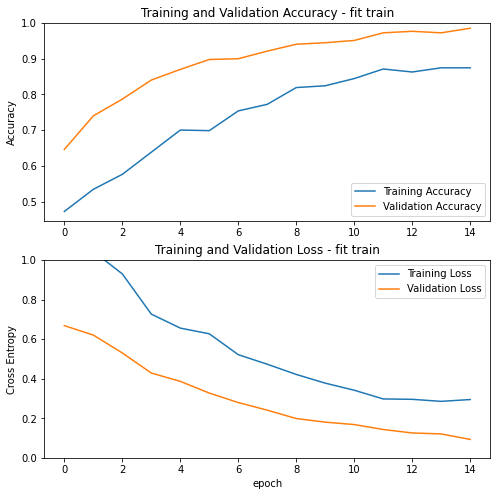

Unfreeze top layers
Number of layers in the base model:  190
Number of trainable variables  84
model fit 2
Epoch 15/20
10/10 [==============================] - 3s 280ms/step - loss: 0.1025 - accuracy: 0.9648 - val_loss: 0.0095 - val_accuracy: 0.9979
Epoch 16/20
10/10 [==============================] - 2s 191ms/step - loss: 0.0191 - accuracy: 0.9950 - val_loss: 0.0105 - val_accuracy: 0.9979
Epoch 17/20
10/10 [==============================] - 2s 188ms/step - loss: 0.0230 - accuracy: 0.9916 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 18/20
10/10 [==============================] - 2s 191ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 19/20
10/10 [==============================] - 2s 189ms/step - loss: 0.0072 - accuracy: 0.9983 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 20/20
10/10 [==============================] - 2s 187ms/step - loss: 0.0039 - accuracy: 0.9983 - val_loss: 6.2485e-04 - val_accuracy: 1.0000


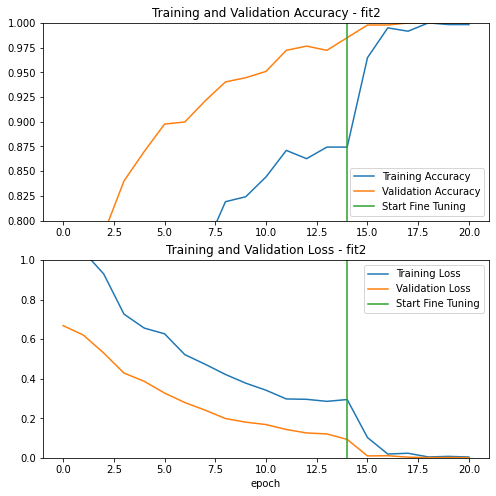

2/2 [==============================] - 0s 28ms/step - loss: 2.5621e-04 - accuracy: 1.0000
Test loss : 0.000256214349064976
Test accuracy : 1.0
Predictions:
 [0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0
 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 1]
Labels:
 [0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0
 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 1]


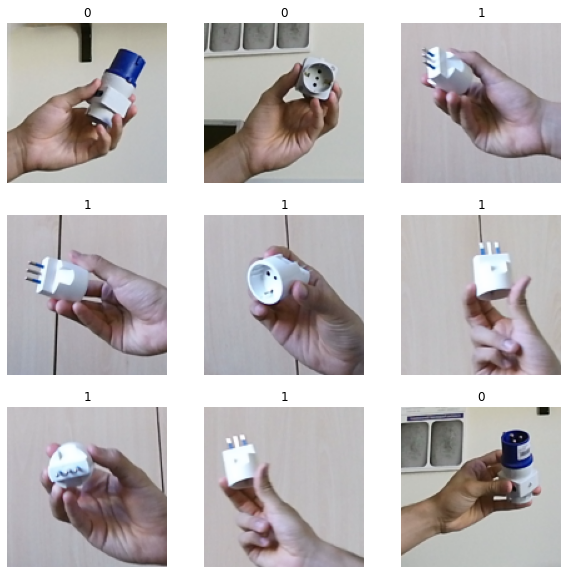

In [66]:
print("# Start of 1st dataset using train_dir0 ...")

train_dir0,validation_dir0,train_dir1,validation_dir1 = source_data(2)

train_dataset0 = trainset(train_dir0,BATCH_SIZE=64)
validation_dataset0 = val_dataset(validation_dir0,BATCH_SIZE=64)
val_batches0,test_dataset0,validation_dataset0 = test_dataset(validation_dataset0)
train_dataset0,validation_dataset0,test_dataset0 = prefetch(train_dataset0,validation_dataset0,test_dataset0)

data_augmentation = data_aug()
preprocess_input, rescale = prepro_rescale()
base_model0 = create_base()

base_model0,image_batch0,label_batch0,feature_batch0 = feature_extractor(base_model0,train_dataset0)
feature_batch_average0 = add_classify_head_layer(feature_batch0)
prediction_batch0 = add_predict_layer(feature_batch_average0)

train_model0 = train_model(base_model0)

evaluate_dataset(train_model0, validation_dataset0)
history0,acc,val_acc,loss,val_loss = fit_train(train_model0,train_dataset0,validation_dataset0,initial_epochs=15)
tune_model0 = tune_base_model(base_model0,train_model0)
history1,acc,val_acc,loss,val_loss = model_fit2(tune_model0,train_dataset0,validation_dataset0,history0,initial_epochs=15,fine_tune_epochs=5,acc=acc,val_acc=val_acc,loss=loss,val_loss=val_loss)
evaluate_model(tune_model0, test_dataset0)
predict_image(tune_model0,test_dataset0)

# Repeat of dataset #1 (train_dir0 ...) using same tuned model that have NOT been changed with dataset #2 yet
2/2 [==============================] - 0s 34ms/step - loss: 3.3223e-04 - accuracy: 1.0000
Test loss : 0.0003322269185446203
Test accuracy : 1.0
Predictions:
 [1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0
 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 1]
Labels:
 [1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0
 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 1]


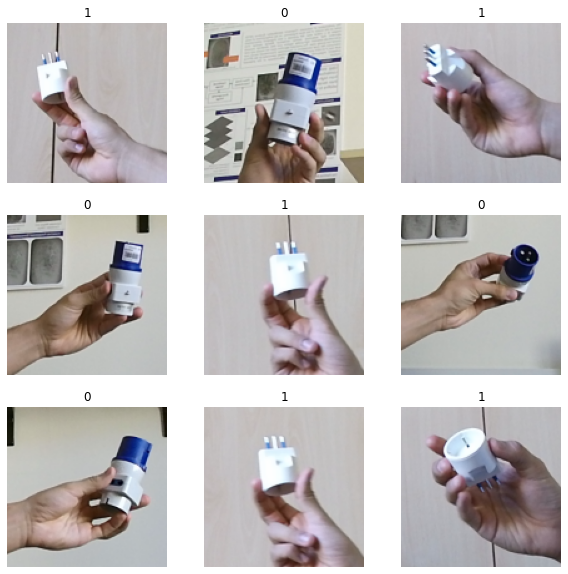

In [67]:
print("# Repeat of dataset #1 (train_dir0 ...) using same tuned model that have NOT been changed with dataset #2 yet")

evaluate_model(tune_model0, test_dataset0)
predict_image(tune_model0,test_dataset0)


# Start of dataset #2 (train_dir1 ...) using same tuned model
Found 600 files belonging to 2 classes.
['o10', 'o11']
Found 600 files belonging to 2 classes.
['o10', 'o11']
Number of validation batches: 8
Number of test batches: 2
<TakeDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>
<SkipDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>
Freezing the convolutional base
(64, 128, 128, 3)
(64,)
(64, 4, 4, 2048)
(64, 2048)
(64, 1)
trainable variables  2
8/8 [==============================] - 1s 84ms/step - loss: 0.7323 - accuracy: 0.7331
initial loss: 0.73
initial accuracy: 0.73
fit train
Epoch 1/25
10/10 [==============================] - 1s 137ms/step - loss: 0.9893 - accuracy: 0.6867 - val_loss: 0.5038 - val_accuracy: 0.7691
Epoch 2/25
10/10 [==============================] - 1s 133ms/step - loss: 0.7214 - accuracy: 0.7150 - val_loss: 0.4382 - val_accuracy: 0.7797
Epoch 3/25
10/10 [==============================] - 1s 132ms/step

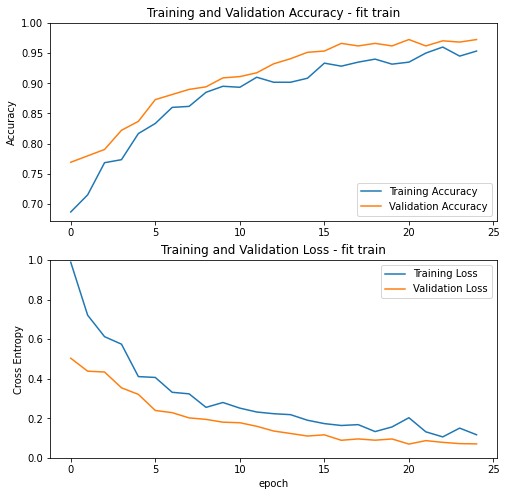

Unfreeze top layers
Number of layers in the base model:  190
Number of trainable variables  84
model fit 2
Epoch 25/30
10/10 [==============================] - 3s 292ms/step - loss: 0.0652 - accuracy: 0.9717 - val_loss: 0.0076 - val_accuracy: 0.9979
Epoch 26/30
10/10 [==============================] - 2s 193ms/step - loss: 0.0224 - accuracy: 0.9933 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 27/30
10/10 [==============================] - 2s 192ms/step - loss: 0.0194 - accuracy: 0.9917 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 28/30
10/10 [==============================] - 2s 195ms/step - loss: 0.0080 - accuracy: 0.9967 - val_loss: 9.0644e-04 - val_accuracy: 1.0000
Epoch 29/30
10/10 [==============================] - 2s 194ms/step - loss: 0.0111 - accuracy: 0.9967 - val_loss: 4.7495e-04 - val_accuracy: 1.0000
Epoch 30/30
10/10 [==============================] - 2s 190ms/step - loss: 0.0096 - accuracy: 0.9983 - val_loss: 5.0764e-04 - val_accuracy: 1.0000


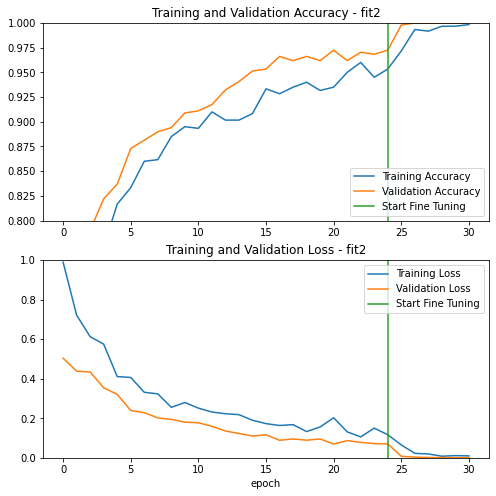

2/2 [==============================] - 0s 29ms/step - loss: 7.5438e-04 - accuracy: 1.0000
Test loss : 0.0007543750107288361
Test accuracy : 1.0
Predictions:
 [0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1
 0 1 1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0]
Labels:
 [0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1
 0 1 1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0]


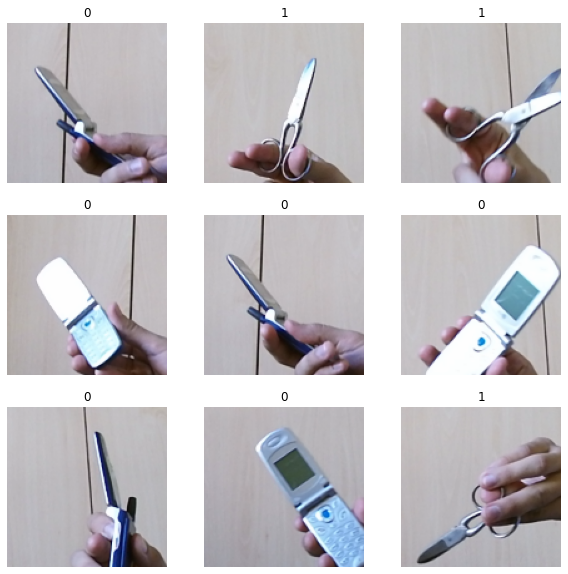

In [68]:
print("# Start of dataset #2 (train_dir1 ...) using same tuned model")

#train_dir0,validation_dir0,train_dir1,validation_dir1 = source_data(2)
train_dataset0 = trainset(train_dir1)
validation_dataset0 = val_dataset(validation_dir1)
val_batches0,test_dataset0,validation_dataset0 = test_dataset(validation_dataset0)
train_dataset0,validation_dataset0,test_dataset0 = prefetch(train_dataset0,validation_dataset0,test_dataset0)

#data_augmentation = data_aug()
#preprocess_input, rescale = prepro_rescale()
#base_model0 = create_base()

base_model0,image_batch0,label_batch0,feature_batch0 = feature_extractor(base_model0,train_dataset0)
feature_batch_average0 = add_classify_head_layer(feature_batch0)
prediction_batch0 = add_predict_layer(feature_batch_average0)

#enabled
train_model0 = train_model(base_model0)

evaluate_dataset(train_model0, validation_dataset0)
history0,acc,val_acc,loss,val_loss = fit_train(train_model0,train_dataset0,validation_dataset0,initial_epochs=25)
tune_model0 = tune_base_model(base_model0,train_model0)
history1,acc,val_acc,loss,val_loss = model_fit2(tune_model0,train_dataset0,validation_dataset0,history0,initial_epochs=25,fine_tune_epochs=5,acc=acc,val_acc=val_acc,loss=loss,val_loss=val_loss)

evaluate_model(tune_model0, test_dataset0)
predict_image(tune_model0,test_dataset0)


Found 597 files belonging to 2 classes.
['o1', 'o2']
Found 597 files belonging to 2 classes.
['o1', 'o2']
Number of validation batches: 8
Number of test batches: 2
<TakeDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>
<SkipDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>
2/2 [==============================] - 0s 38ms/step - loss: 1.4446 - accuracy: 0.6719
Test loss : 1.4446194171905518
Test accuracy : 0.671875
Predictions:
 [1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1]
Labels:
 [1 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0
 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0]


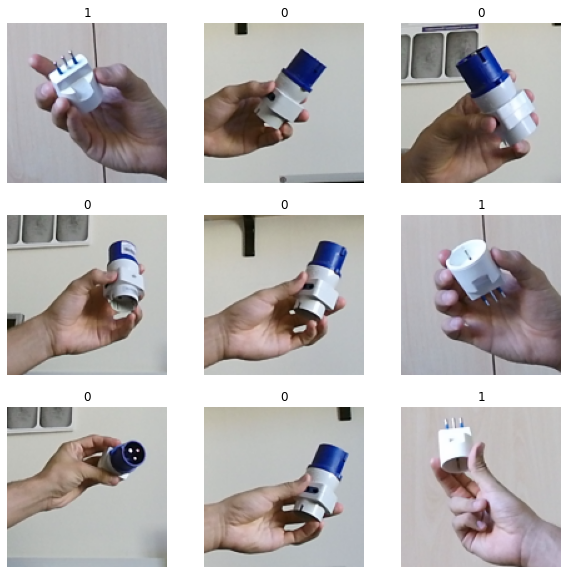

In [69]:
# Repeat of dataset #1 (train_dir0 ...) using same tuned model that have been changed with dataset #2

#train_dir0,validation_dir0,train_dir1,validation_dir1 = source_data(2)
train_dataset0 = trainset(train_dir0)
validation_dataset0 = val_dataset(validation_dir0)

val_batches0,test_dataset0,validation_dataset0 = test_dataset(validation_dataset0)
train_dataset0,validation_dataset0,test_dataset0 = prefetch(train_dataset0,validation_dataset0,test_dataset0)

evaluate_model(tune_model0, test_dataset0)
predict_image(tune_model0,test_dataset0)



Found 600 files belonging to 2 classes.
['o10', 'o11']
Found 600 files belonging to 2 classes.
['o10', 'o11']
Number of validation batches: 8
Number of test batches: 2
<TakeDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>
<SkipDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>
2/2 [==============================] - 0s 33ms/step - loss: 8.5131e-05 - accuracy: 1.0000
Test loss : 8.513127249898389e-05
Test accuracy : 1.0
Predictions:
 [1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0
 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1]
Labels:
 [1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0
 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1]


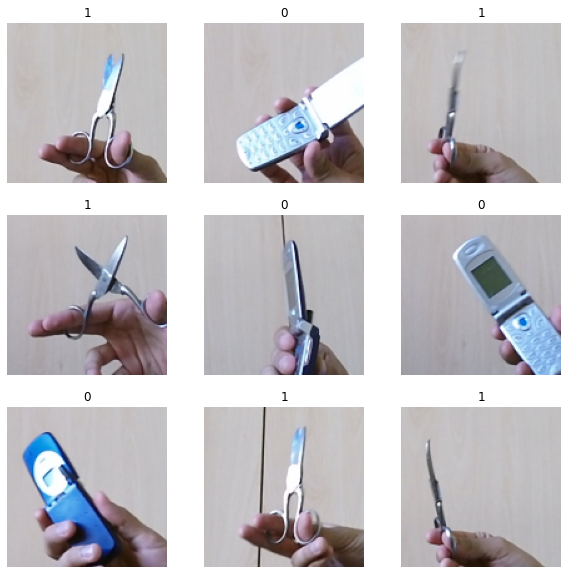

In [70]:
# Repeat of dataset #2 (train_dir1 ...) using same tuned model that have been changed

#train_dir0,validation_dir0,train_dir1,validation_dir1 = source_data(2)
train_dataset0 = trainset(train_dir1)
validation_dataset0 = val_dataset(validation_dir1)

val_batches0,test_dataset0,validation_dataset0 = test_dataset(validation_dataset0)
train_dataset0,validation_dataset0,test_dataset0 = prefetch(train_dataset0,validation_dataset0,test_dataset0)

evaluate_model(tune_model0, test_dataset0)
predict_image(tune_model0,test_dataset0)

# combined 1st and 2nd dataset ...
/home/ubuntu/cvpr_clvision_challenge/core50/data/core50_128x128
data source 0 is 3
Found 1197 files belonging to 4 classes.
['o1', 'o10', 'o11', 'o2']
Found 1197 files belonging to 4 classes.
['o1', 'o10', 'o11', 'o2']
Number of validation batches: 16
Number of test batches: 3
<TakeDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>
<SkipDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>
3/3 [==============================] - 0s 39ms/step - loss: 0.0058 - accuracy: 0.2135
Test loss : 0.005755424499511719
Test accuracy : 0.2135416716337204
Predictions:
 [0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0]
Labels:
 [3 3 2 0 0 0 2 1 2 0 1 0 1 2 3 1 2 2 2 3 3 3 1 2 0 0 0 1 2 0 0 3 3 2 0 1 1
 3 3 1 0 1 2 3 3 1 2 1 1 2 3 2 1 0 1 2 3 1 2 0 2 0 3 0]


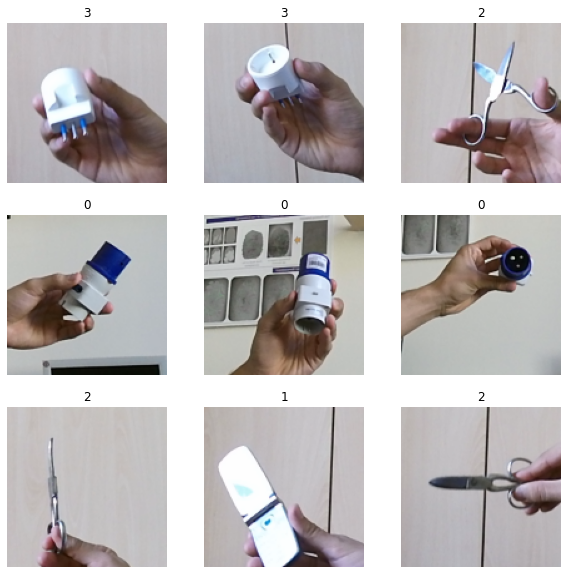

In [71]:
print("# combined 1st and 2nd dataset ...")

train_dir0,validation_dir0,train_dir1,validation_dir1 = source_data(4)

train_dataset0 = trainset(train_dir0,BATCH_SIZE=64)
validation_dataset0 = val_dataset(validation_dir0,BATCH_SIZE=64)
val_batches0,test_dataset0,validation_dataset0 = test_dataset(validation_dataset0)
train_dataset0,validation_dataset0,test_dataset0 = prefetch(train_dataset0,validation_dataset0,test_dataset0)

'''
data_augmentation = data_aug()
preprocess_input, rescale = prepro_rescale()
base_model0 = create_base()

base_model0,image_batch0,label_batch0,feature_batch0 = feature_extractor(base_model0,train_dataset0)
feature_batch_average0 = add_classify_head_layer(feature_batch0)
prediction_batch0 = add_predict_layer(feature_batch_average0)

train_model0 = train_model(base_model0)

evaluate_dataset(train_model0, validation_dataset0)
history0,acc,val_acc,loss,val_loss = fit_train(train_model0,train_dataset0,validation_dataset0,initial_epochs=15)

tune_model0 = tune_base_model(base_model0,train_model0)
history1,acc,val_acc,loss,val_loss = model_fit2(tune_model0,train_dataset0,validation_dataset0,history0,initial_epochs=15,fine_tune_epochs=5,acc=0,val_acc=0,loss=0,val_loss=0)
'''


evaluate_model(tune_model0, test_dataset0)
predict_image(tune_model0,test_dataset0)